In [4]:
import os 
import shutil
import xml.etree.ElementTree as ET
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from sklearn.model_selection import train_test_split

plt.rcParams['figure.figsize'] = (16, 12)
matplotlib.rc('xtick', labelsize=14) 
matplotlib.rc('ytick', labelsize=14) 

In [5]:
# locations of data
vins = 'D:\\Masters Data\\VINS Dataset'
dirs = ['Android', 'iphone', 'Rico', 'uplabs']
a_dir_name = 'Annotations'
i_dir_name = 'JPEGImages'
target = os.path.join(os.path.join(os.getcwd(), 'datasets'), 'vins')

In [6]:
# Function to get the data from xml annotation
def parse_xml(xml_file):
    root = ET.parse(xml_file).getroot()
    
    # Initialise the annotations dict 
    a_dict = {}
    a_dict['bboxes'] = []

    # Parse the XML Tree
    for elem in root:
        # Get the file name 
        if elem.tag == 'filename':
            a_dict['filename'] = elem.text
        if elem.tag == 'file':
            a_dict['filename'] = elem.text + '.jpg'
            
        # Get the image size
        elif elem.tag == 'size':
            image_size = []
            for subelem in elem:
                image_size.append(int(subelem.text.split('.')[0]))
            
            a_dict['image_size'] = tuple(image_size)
        
        # Get details of the bounding box 
        elif elem.tag == 'object':
            bbox = {}
            for subelem in elem:
                if subelem.tag == 'name':
                    bbox['class'] = subelem.text
                    
                elif subelem.tag == 'bndbox':
                    for subsubelem in subelem:
                        bbox[subsubelem.tag] = int(subsubelem.text.split('.')[0])            
            a_dict['bboxes'].append(bbox)
    
    return a_dict

In [7]:
# Function to convert the annotations dict to YOLO format
def dic2yolo(a_dict):
    out = []
    
    # For each bounding box
    for b in a_dict['bboxes']:
        if not b['class'] in class_name_to_id_mapping:
            continue
        class_id = class_name_to_id_mapping[b["class"]]
        
        # Transform the bbox co-ordinates to YOLO format
        b_center_x = (b['xmin'] + b['xmax']) / 2 
        b_center_y = (b['ymin'] + b['ymax']) / 2
        b_width    = (b['xmax'] - b['xmin'])
        b_height   = (b['ymax'] - b['ymin'])
        
        # Normalise the co-ordinates by the dimensions of the image
        image_w, image_h, image_c = a_dict['image_size']
        b_center_x /= image_w 
        b_center_y /= image_h 
        b_width    /= image_w 
        b_height   /= image_h 
        
        # format the output
        out.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
        
    return out

## Getting all classes and plotting frequency histogram

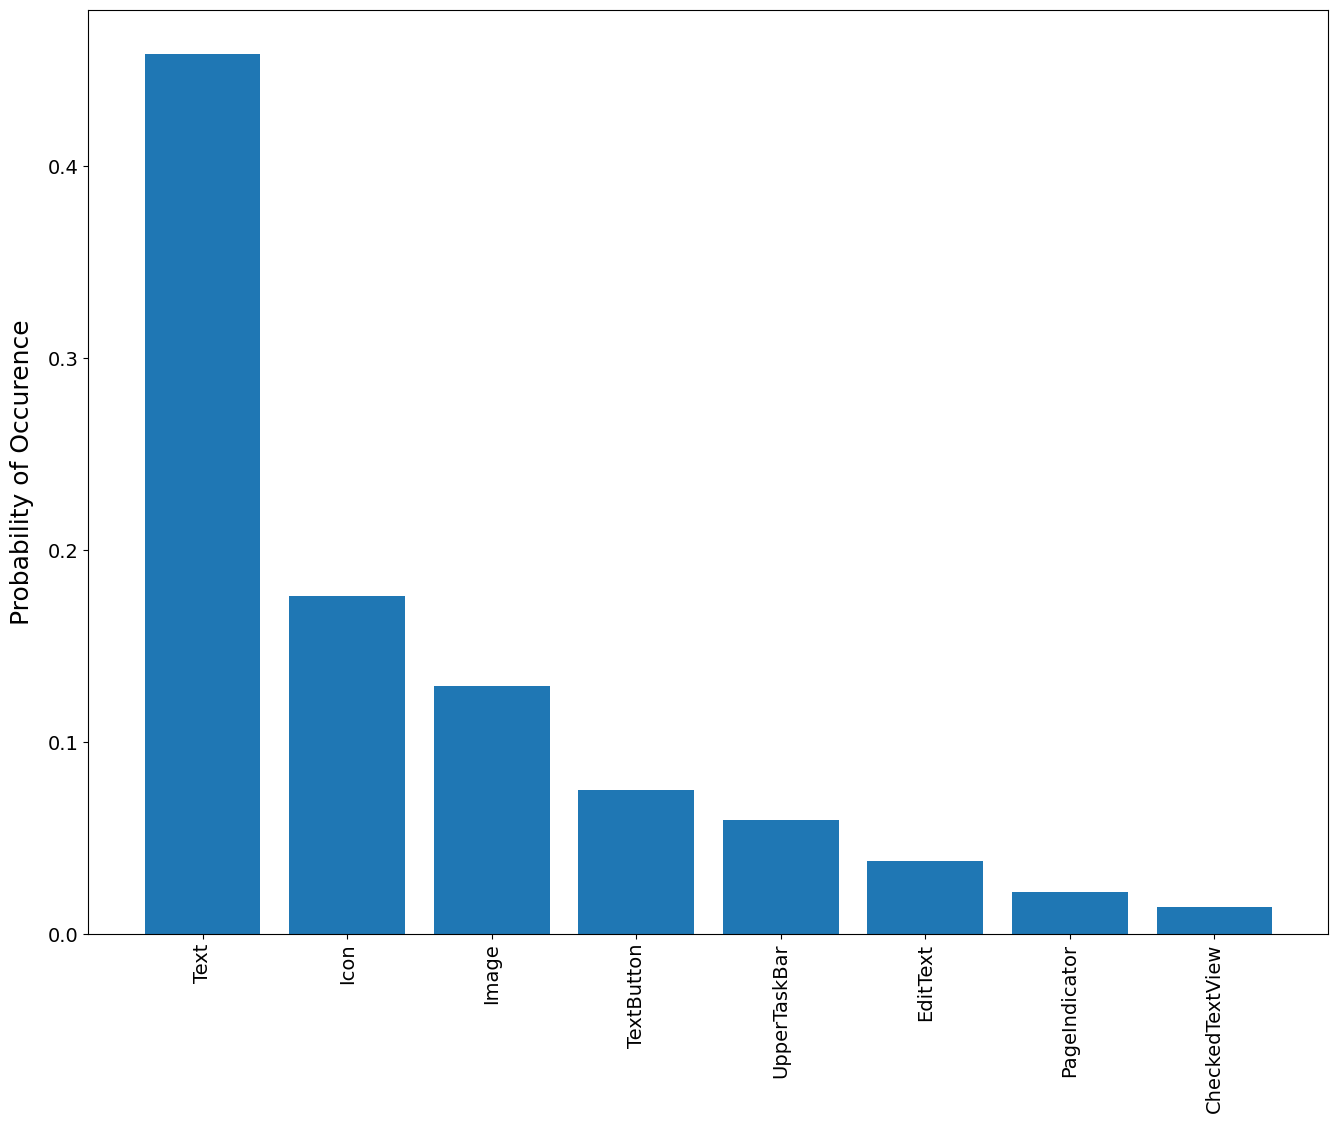

{'Text': 0, 'Icon': 1, 'Image': 2, 'TextButton': 3, 'UpperTaskBar': 4, 'EditText': 5, 'PageIndicator': 6, 'CheckedTextView': 7}


In [8]:
classes = []

for di in dirs: 
    data_dir = os.path.join(os.path.join(vins, di), a_dir_name)

    for fn in os.listdir(data_dir):
        if fn.split('.')[1] != 'xml':
            continue
        classes += [d['class'] for d in parse_xml(os.path.join(data_dir, fn))['bboxes']]
        
c = pd.Series(classes).value_counts()
c /= c.sum()

# select only classes with decent stats
c = c[c>0.01]

plt.bar(c.index, c.values)
plt.ylabel('Probability of Occurence', labelpad=10, fontsize=18)
plt.xticks(rotation=90)
plt.show()

# maps class names to IDs
class_name_to_id_mapping = {}
for i in range(len(c)):
    class_name_to_id_mapping[c.index[i]] = i
print(class_name_to_id_mapping)

## Coverting all annotations from xml to YOLO txt

In [9]:
for di in dirs: 
    data_dir = os.path.join(os.path.join(vins, di), a_dir_name)
    annotations = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if x[-3:] == "xml"]
    annotations.sort()

    for fn in tqdm(annotations):
        a_dict = parse_xml(os.path.join(data_dir, fn))
        out = dic2yolo(a_dict)
        if len(out) > 0:
            out_fn = os.path.join(data_dir, a_dict['filename'].replace('jpg', 'txt'))
            print('\n'.join(out), file= open(out_fn, 'w'))  

100%|██████████████████████████████████████████████████████████████████████████████| 603/603 [00:00<00:00, 2190.57it/s]


## Visual test of annotations working on a random image

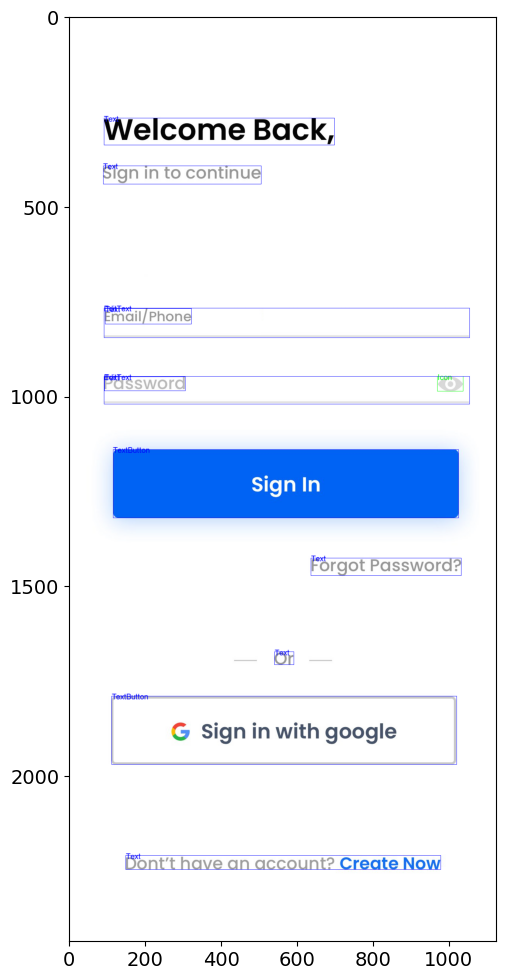

In [10]:
class_id_to_name_mapping = dict(zip(class_name_to_id_mapping.values(), class_name_to_id_mapping.keys()))
colors = {
    'Text': (0, 0, 255), 
    'Icon': (0, 255, 0), 
    'Image': (0, 255, 0), 
    'TextButton': (0, 0, 255), 
    'UpperTaskBar': (255, 0, 0), 
    'EditText': (0, 0, 255), 
    'PageIndicator': (255, 0, 0), 
    'CheckedTextView': (0, 0, 255)
}

# random pick
data_dir = os.path.join(os.path.join(vins, dirs[np.random.randint(len(dirs))]), a_dir_name)
a_fn = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if x[-3:] == "txt"]
fn = a_fn[np.random.randint(len(fn))]

# read annotations
with open(fn, 'r') as file:
    a = file.read().split('\n')[:-1]

a = [x.split(' ') for x in a]
a = np.array([[float(y) for y in x ] for x in a])

# get image
ifn = fn.replace(a_dir_name, i_dir_name).replace('txt', 'jpg')
assert os.path.exists(ifn)
img = Image.open(ifn)
w, h = img.size

# convert YOLO to pixels
a_scaled = np.copy(a)
a_scaled[:,[1,3]] = a[:,[1,3]] * w
a_scaled[:,[2,4]] = a[:,[2,4]] * h 
a_scaled[:,1:3] = a_scaled[:,1:3] - (a_scaled[:,3:5] / 2)
a_scaled[:,3:5] = a_scaled[:,1:3] + a_scaled[:,3:5]

# draw boxes
out = ImageDraw.Draw(img)
for ann in a_scaled:
    obj_cls, x0, y0, x1, y1 = ann
    txt = class_id_to_name_mapping[(int(obj_cls))]
    col = colors[txt]
    
    out.rectangle([(x0, y0), (x1, y1)], outline=col)
        
    out.text((x0, y0 - 10), txt, font=ImageFont.truetype('arial.ttf', 20), fill=col)

plt.imshow(np.array(img))
plt.show()


## Dataset Partitioning

In [21]:
# Read images and annotations
images, annotations, ifn, afn = [], [], [], []
for di in dirs: 
    im_dir = os.path.join(os.path.join(vins, di), i_dir_name)
    an_dir = os.path.join(os.path.join(vins, di), a_dir_name)
    ifn += [x.split('.')[0] for x in os.listdir(im_dir) if x[-3:] == 'jpg']
    afn += [x.split('.')[0] for x in os.listdir(an_dir) if x[-3:] == 'txt']
    
# No guarantee that database is consistent
intersection = pd.Index(ifn).intersection(pd.Index(afn)).tolist()
    
for di in dirs: 
    im_dir = os.path.join(os.path.join(vins, di), i_dir_name)
    an_dir = os.path.join(os.path.join(vins, di), a_dir_name)
    images += [os.path.join(im_dir, x) for x in os.listdir(im_dir) if x[:-4] in intersection]
    annotations += [os.path.join(an_dir, x) for x in os.listdir(an_dir) if (x[:-4] in intersection) & (x[-3:] == 'txt')]

images.sort()
annotations.sort()

# Split the dataset 80:10:10 (YOLO uses labels rather than annotations)
train_images, val_images, train_labels, val_labels = train_test_split(
    images, annotations, test_size = 0.2, random_state = 1
)
val_images, test_images, val_labels, test_labels = train_test_split(
    val_images, val_labels, test_size = 0.5, random_state = 1
)

# Creat directories and move splits
my_vars = locals()
for data_split in ['train', 'val', 'test']:
    for data_type in tqdm(['images', 'labels']):
        base_dir = os.path.join(target, data_split)
        destination = os.path.join(base_dir, data_type)
        if os.path.exists(destination):
            shutil.rmtree(destination, ignore_errors=True)
        os.makedirs(destination)
        for fn in my_vars[f'{data_split}_{data_type}']:
            try:
                shutil.copy(fn, destination)
            except:
                print(f)
                assert False

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.19it/s]


In [40]:
# create yaml
out = [
    'train: datasets/vins/train/images',
    'val: datasets/vins/val/images',
    f'nc: {len(class_name_to_id_mapping)}',
    f'names: {list(class_name_to_id_mapping)}'
]
print('\n'.join(out), file= open('datasets/vins.yaml', 'w'))  